# Exercise 1. Pirate Attacks

 Use KNN, Naive Bayes and SVM on the ‘Pirate Attacks’ dataset to predict pirate attack success:

   - Clean and preprocess data using one-hot-encoder or pipeline for categorical variables.

   - Run the three models on the data. 


Have you noticed something strange? There is a “data leakage” here..

   - Identify the feature(s) that are giving away the result!

   - Run you models again. Which model is the best in predicting attacks?

## Import Libraries and Preprocess the Data

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as cm
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [47]:
data = pd.read_csv('../../data/pirate_data.csv', delimiter=',',index_col=0)

<b> Goal:</b> Predict Pirate Attack Success

In [48]:
data.head()

,DATETIME (LOCAL),DATETIME (UTC),DATE (LT),DATE (UTC),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACKS,ATTACK SUCCESS
1,2016-01-30 23:34:00,2016-01-30 22:34:00,2016-01-30,2016-01-30,WEST AFRICA,NIGERIA,"FAILED ATTACK, HIJACKING",CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,1,0
2,2016-01-29 23:40:00,2016-01-29 22:40:00,2016-01-29,2016-01-29,WEST AFRICA,NIGERIA,KIDNAP/RANSOM AT SEA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,1
3,2016-01-28 03:00:00,2016-01-28 02:00:00,2016-01-28,2016-01-28,SOUTH ASIA,INDIA,"FAILED ATTACK, ROBBERY",PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,1,0
4,NaN,NaN,2016-01-27,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,SUSPICIOUS ACTIVITY AT SEA,NaN,0,OFF SHORE,13.998747,54.112792,Asia/Riyadh,UNKNOWN,1,0
5,2016-01-25 23:55:00,2016-01-25 22:55:00,2016-01-25,2016-01-25,SOUTH AMERICA,VENEZUELA,THEFT AT ANCHORAGE,GENERAL CARGO VESSEL,0,ANCHORAGE,10.267500,-63.432500,America/Caracas,EVENING,1,1


* 'Unnamed: 0': Leave out as it's an artifact
* 'DATETIME (LOCAL)': Leave out as it's too granular
* 'DATETIME (UTC)': Leave out as it's too granular
* 'DATE (LT)': Leave it in for the time being, but only focus on months as it's too granular
* 'DATE (UTC)': Leave out, as we only need one type of date information (LT) here
* 'REGION': Leave it in
* 'COUNTRY': Leave it in
* 'INCIDENT TYPE': Leave out, it constitutes data leakage
* 'VESSEL TYPE': Leave it in
* 'MAERSK?': Leave it out, a specific shipping company is not the focus here
* 'VESSEL ACTIVITY LOCATION': Leave it in
* 'LAT': Leave out as it's too granular, we have region and country for this
* 'LONG': Leave out as it's too granular, we have region and country for this
* 'TIMEZONE': Leave out
* 'TIME OF DAY': leave it in, but convert to numbers
* 'ATTACKS': could be left out as it's all ones anyway (see below), but we'll leave it in for data exploration
* 'ATTACK SUCCESS': leave it in (this will be the target variable, it is based on 'INCIDENT TYPE')

### Drop useless columns and leakage (incident type)
#### Columns chosen based on common sence

In [49]:
data.columns

Index(['DATETIME (LOCAL)', 'DATETIME (UTC)', 'DATE (LT)', 'DATE (UTC)',
       'REGION', 'COUNTRY', 'INCIDENT TYPE', 'VESSEL TYPE', 'MAERSK?',
       'VESSEL ACTIVITY LOCATION', 'LAT', 'LONG', 'TIMEZONE', 'TIME OF DAY',
       'ATTACKS', 'ATTACK SUCCESS'],
      dtype='object')

In [50]:
data = data.drop(['DATETIME (LOCAL)',
                  'DATETIME (UTC)',
                  'DATE (UTC)',
                  'MAERSK?',
                  'LAT',
                  'LONG',
                  'TIMEZONE',
                  'INCIDENT TYPE'], 1)
data.columns

Index(['DATE (LT)', 'REGION', 'COUNTRY', 'VESSEL TYPE',
       'VESSEL ACTIVITY LOCATION', 'TIME OF DAY', 'ATTACKS', 'ATTACK SUCCESS'],
      dtype='object')

#### Check for missing values

In [51]:
data.isna().sum()

DATE (LT)                     0
REGION                        0
COUNTRY                       0
VESSEL TYPE                 164
VESSEL ACTIVITY LOCATION    126
TIME OF DAY                   0
ATTACKS                       0
ATTACK SUCCESS                0
dtype: int64

In [52]:
data.shape

(802, 8)

VESSEL TYPE and VESSEL ACTIVITY LOCATION have missing values (around 15%), we still can delete them. 

Other options would be: 
  - impute the data with one of sklearn.impute methods. Beware when impute categorical data. 
  - put NaNs into Unknown category and handle it with OneHotEncoder. 


In [53]:
data = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [54]:
data.shape

(617, 8)

#### Further feature engineering

Which other columns we can delete? 'ATTACKS' column has only ones, so it does not provide any information. 

In [55]:
data['ATTACKS'].value_counts()

1    617
Name: ATTACKS, dtype: int64

The 'DATE (LT)' itself also is useless, but we cab extract valuable information out of it:

In [56]:
data['MONTH'] = pd.DatetimeIndex(data['DATE (LT)']).month.astype(str)
data['WEEKDAY'] = pd.DatetimeIndex(data['DATE (LT)']).weekday.astype(str)
data.head()

,DATE (LT),REGION,COUNTRY,VESSEL TYPE,VESSEL ACTIVITY LOCATION,TIME OF DAY,ATTACKS,ATTACK SUCCESS,MONTH,WEEKDAY
1,2016-01-30,WEST AFRICA,NIGERIA,CONTAINER SHIP,OFF SHORE,EVENING,1,0,1,5
2,2016-01-29,WEST AFRICA,NIGERIA,PRODUCT TANKER,OFF SHORE,EVENING,1,1,1,4
3,2016-01-28,SOUTH ASIA,INDIA,PRODUCT TANKER,ANCHORAGE,NIGHT,1,0,1,3
5,2016-01-25,SOUTH AMERICA,VENEZUELA,GENERAL CARGO VESSEL,ANCHORAGE,EVENING,1,1,1,0
6,2016-01-25,SOUTH ASIA,INDIA,PRODUCT TANKER,OFF SHORE,NIGHT,1,1,1,0


In [57]:
data = data.drop(['DATE (LT)'], 1)
data = data.drop(['ATTACKS'], 1)

In [58]:
data.columns

Index(['REGION', 'COUNTRY', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION',
       'TIME OF DAY', 'ATTACK SUCCESS', 'MONTH', 'WEEKDAY'],
      dtype='object')

In [60]:
# Separate the feature variables X and the target variable y (Successful Attack):
X = data.drop(['ATTACK SUCCESS'], 1)
y = data['ATTACK SUCCESS']

In [61]:
X.head()

,REGION,COUNTRY,VESSEL TYPE,VESSEL ACTIVITY LOCATION,TIME OF DAY,MONTH,WEEKDAY
1,WEST AFRICA,NIGERIA,CONTAINER SHIP,OFF SHORE,EVENING,1,5
2,WEST AFRICA,NIGERIA,PRODUCT TANKER,OFF SHORE,EVENING,1,4
3,SOUTH ASIA,INDIA,PRODUCT TANKER,ANCHORAGE,NIGHT,1,3
5,SOUTH AMERICA,VENEZUELA,GENERAL CARGO VESSEL,ANCHORAGE,EVENING,1,0
6,SOUTH ASIA,INDIA,PRODUCT TANKER,OFF SHORE,NIGHT,1,0


In [63]:
y.head()

1    0
2    1
3    0
5    1
6    1
Name: ATTACK SUCCESS, dtype: int64

### Perform Train-Test Split on the final dataset

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(462, 7)
(155, 7)
(462,)
(155,)


### Introduce Encoding 

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')

#  Running models

## KNN

In [105]:
from sklearn.neighbors import KNeighborsClassifier

#Call model into variable
knn = KNeighborsClassifier(n_neighbors=1)
knn = Pipeline([('one_hot_enc', ohe), ('estimator', knn)])

In [106]:
knn_score = np.mean(
    cross_val_score(knn,
                    X_train,
                    y_train,
                    scoring = 'f1',
                    cv=4))
knn_score

0.6361864260778891

## Naive Bayes

In [107]:
#Choosing Bernoulli, as input variables are binary after One-Hot-Encoding
from sklearn.naive_bayes import BernoulliNB

#Call model into variable
nb = BernoulliNB()

nb = Pipeline([('one_hot_enc', ohe), ('estimator', nb)])

In [108]:
nb_score = np.mean(
    cross_val_score(nb,
                    X_train,
                    y_train,
                    scoring = 'f1',
                    cv=4))
nb_score

0.6389140725321543

## SVM

### Linear Support Vector Classification

In [109]:

from sklearn.svm import LinearSVC

#Call model into variable
svm = LinearSVC()
svm = Pipeline([('one_hot_enc', ohe), ('estimator', svm)])

In [110]:
svm_score =  np.mean(
    cross_val_score(svm,
                    X_train,
                    y_train,
                    scoring = 'f1',
                    cv=4))
svm_score  

0.641906733077042

### Support Vector Classification with Radial Basis Function

In [111]:
from sklearn.svm import SVC

#Call model into variable
svm_rbf = SVC(kernel='rbf',gamma='scale')
svm_rbf = Pipeline([('one_hot_enc', ohe), ('estimator', svm_rbf)])


In [112]:
svm_rbf_score =  np.mean(
    cross_val_score(svm_rbf,
                    X_train,
                    y_train,
                    scoring = 'f1',
                    cv=4))
svm_rbf_score  

0.7151401670626374

## Let's find the best model 

In [118]:
models = ['knn', 'nb', 'svm', 'svm_rbf']

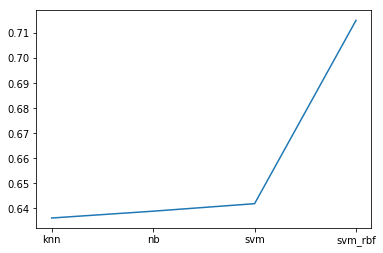

In [120]:
plt.plot(models,[knn_score, nb_score, svm_score, svm_rbf_score]);

# Results of the best model

## Classification report

In [103]:
#Train model
svm_rbf.fit(X_train,y_train)
print(svm)

#SVM predict
svm_predictions = svm_rbf.predict(X_test)

print("-------------------------------------------------------------")
svm_rbf_cm = confusion_matrix(y_test,svm_predictions)
print(svm_rbf_cm)

print("-------------------------------------------------------------")
print(classification_report(y_test,svm_predictions))

print("-------------------------------------------------------------")
print(svm_rbf.score(X_test,y_test))

Pipeline(memory=None,
         steps=[('one_hot_enc',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', n_values=None,
                               sparse=True)),
                ('estimator',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
-------------------------------------------------------------
[[17 44]
 [11 83]]
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.28      0.38        61
           1       0.65      0.88      0.75        

using radial basis function is slightly worse, so probably not a good kernel for this data set